# Camera Predictions

In [2]:
!pip install -qr requirements.txt

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [66]:
import io
import re
import boto3
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [4]:
s3 = boto3.resource("s3")
bucket = s3.Bucket("ap-unsplash-images")

In [59]:
clean_focal_length = lambda fl: re.sub(r"[ m]","",fl)
is_valid_focal_length = lambda fl: len(set(fl).difference(".1234567890")) == 0

In [60]:
df[df.exif_focal_length.apply(clean_focal_length).apply(lambda fl: not is_valid_focal_length(fl))]

,photo_id,photo_image_url,photo_width,photo_height,photo_aspect_ratio,exif_camera_make,exif_camera_model,exif_iso,exif_aperture_value,exif_focal_length,exif_exposure_time,s3_key,s3_bucket
1889,dtWq8WU2zxU,https://images.unsplash.com/photo-1547700094-a...,3456,4320,0.80,Canon,EOS T6,200.0,4.0,75-300,1/100,lite-normalized/unsplash.lite.dtWq8WU2zxU.JPG,ap-unsplash-images
7078,MCHJUROkf4Q,https://images.unsplash.com/photo-1543877058-a...,2592,3872,0.67,Sony,Alpha DSLR-A100,100.0,5.6,70-300,1/125,lite-normalized/unsplash.lite.MCHJUROkf4Q.JPG,ap-unsplash-images
15148,Jz2wA20zdlw,https://images.unsplash.com/photo-1550132460-e...,4032,2672,1.51,Apple,iPhone X,20.0,1.8,4.0 ~ 28mm,1/208,lite-normalized/unsplash.lite.Jz2wA20zdlw.JPG,ap-unsplash-images
17759,c0G9AIZURck,https://images.unsplash.com/photo-156434504283...,2695,4042,0.67,Canon,EOS 1200D,100.0,4.0,18-50,1/320,lite-normalized/unsplash.lite.c0G9AIZURck.JPG,ap-unsplash-images


In [80]:
df.exif_focal_length = df.exif_focal_length.apply(clean_focal_length)

MAX_FOCAL_LENGTH = 200
subdf = df[
    (df.exif_focal_length.apply(is_valid_focal_length)) &
    (subdf.exif_focal_length < MAX_FOCAL_LENGTH)
][["s3_key","exif_focal_length"]]

subdf.exif_focal_length = subdf.exif_focal_length.apply(float)

subdf.head()

,s3_key,exif_focal_length
0,lite-normalized/unsplash.lite.2Q8zDWkj0Yw.JPG,50.0
2,lite-normalized/unsplash.lite.A93gsuMxVcE.JPG,18.0
3,lite-normalized/unsplash.lite.oYIdH6bFssk.JPG,105.0
4,lite-normalized/unsplash.lite.wgLPy2YBXuc.JPG,4.8
5,lite-normalized/unsplash.lite.W4rUHIw3pd0.JPG,120.0


In [81]:
len(subdf)

19484

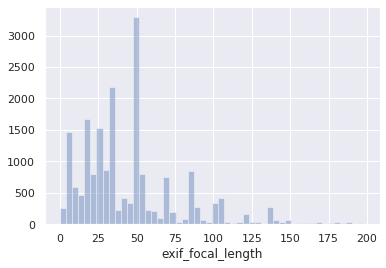

In [82]:
sns.distplot(subdf.exif_focal_length,kde=False)

In [5]:
with io.BytesIO() as b:
    bucket.download_fileobj("lite-normalized-photos.csv",b)
    b.seek(0)
    df = pd.read_csv(b)

df.head()

,photo_id,photo_image_url,photo_width,photo_height,photo_aspect_ratio,exif_camera_make,exif_camera_model,exif_iso,exif_aperture_value,exif_focal_length,exif_exposure_time,s3_key,s3_bucket
0,2Q8zDWkj0Yw,https://images.unsplash.com/photo-141520117961...,4192,2794,1.50,NIKON CORPORATION,NIKON D700,2000.0,2.5,50.0,1/125,lite-normalized/unsplash.lite.2Q8zDWkj0Yw.JPG,ap-unsplash-images
1,tsBDNuCJiLg,https://images.unsplash.com/photo-141768928330...,4324,2880,1.50,NIKON CORPORATION,NIKON D3200,320.0,7.1,200.0,1/2000,lite-normalized/unsplash.lite.tsBDNuCJiLg.JPG,ap-unsplash-images
2,A93gsuMxVcE,https://images.unsplash.com/photo-142981401899...,2000,1333,1.50,Canon,Canon EOS REBEL T2i,400.0,14.0,18.0,1/640,lite-normalized/unsplash.lite.A93gsuMxVcE.JPG,ap-unsplash-images
3,oYIdH6bFssk,https://images.unsplash.com/photo-143275722183...,4288,2848,1.51,NIKON CORPORATION,NIKON D5000,250.0,5.6,105.0,1/30,lite-normalized/unsplash.lite.oYIdH6bFssk.JPG,ap-unsplash-images
4,wgLPy2YBXuc,https://images.unsplash.com/photo-143205996405...,5312,2988,1.78,SAMSUNG,SAMSUNG-SM-G870A,40.0,2.2,4.8,1/2384,lite-normalized/unsplash.lite.wgLPy2YBXuc.JPG,ap-unsplash-images


In [6]:
bucket.download_file(df.loc[0,"s3_key"],"data/test-img.jpg")

# Predicting Camera Focal Length

In [7]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [40]:
df[["s3_key","exif_focal_length"]].head().values

array([['lite-normalized/unsplash.lite.2Q8zDWkj0Yw.JPG', '50.0'],
       ['lite-normalized/unsplash.lite.tsBDNuCJiLg.JPG', '200.0'],
       ['lite-normalized/unsplash.lite.A93gsuMxVcE.JPG', '18.0'],
       ['lite-normalized/unsplash.lite.oYIdH6bFssk.JPG', '105.0'],
       ['lite-normalized/unsplash.lite.wgLPy2YBXuc.JPG', '4.8']],
      dtype=object)

In [36]:
d = tf.data.Dataset.from_generator(lambda: df[["s3_key","exif_focal_length"]].values, output_types=)
d

<FlatMapDataset shapes: <unknown>, types: tf.float32>

In [38]:
list(d)[0]

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 1.], dtype=float32)>

In [13]:
Sequential.fit?

Signature:
Sequential.fit(
    self,
    x=None,
    y=None,
    batch_size=None,
    epochs=1,
    verbose=1,
    callbacks=None,
    validation_split=0.0,
    validation_data=None,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None,
    validation_batch_size=None,
    validation_freq=1,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
)
Docstring:
Trains the model for a fixed number of epochs (iterations on a dataset).

Arguments:
    x: Input data. It could be:
      - A Numpy array (or array-like), or a list of arrays
        (in case the model has multiple inputs).
      - A TensorFlow tensor, or a list of tensors
        (in case the model has multiple inputs).
      - A dict mapping input names to the corresponding array/tensors,
        if the model has named inputs.
      - A `tf.data` dataset. Should return a tuple
        of either `(inputs, targets)` or
        `(input

In [9]:
def make_model():
    vgg = VGG16(include_top=False,input_shape=(512,512,3))
    m = Sequential()
    m.add(vgg)
    

Signature: tf.io.read_file(filename, name=None)
Docstring:
Reads and outputs the entire contents of the input filename.

Args:
  filename: A `Tensor` of type `string`.
  name: A name for the operation (optional).

Returns:
  A `Tensor` of type `string`.
File:      ~/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py
Type:      function


In [40]:
class FoculLengthDataset(Dataset):
    def __init__(self, df):
        # Connect to S3
        s3 = boto3.resource("s3")
        self.s3_bucket = s3.Bucket("ap-unsplash-images")
        # Store the DataFrame
        self.df = df.reset_index(drop=True)[["s3_key","exif_focal_length"]]
        # Build transforms
        self.transforms = transforms.Compose([
            transforms.Resize((512,512)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.56040615,0.36607313,0.42010993],
                std=[0.2895784,0.23586935,0.22863376]
            )
        ])
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,i):
        label = self.df.loc[i,"exif_focal_length"]
        s3key = self.df.loc[i,"s3_key"]
        with io.BytesIO() as b:
            self.s3_bucket.download_fileobj(s3key,b)
            b.seek(0)
            tens = self.transforms(Image.open(b))
        return label, tens

In [41]:
indexes = np.arange(len(df))
i_train, i_val = train_test_split(indexes,test_size=0.15)

train_dataset = FoculLengthDataset(df.iloc[i_train])
val_dataset = FoculLengthDataset(df.iloc[i_val])

In [42]:
BATCH_SIZE = 64

In [43]:
train_loader = DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE)
val_loader = DataLoader(dataset=val_dataset,batch_size=BATCH_SIZE)

In [44]:
train_dataset[0]

AttributeError: module 'PIL.TiffTags' has no attribute 'IFD'

In [54]:
from skimage import io as imgio

In [55]:
# train_dataset.transforms()
img = imgio.imread("data/test-img.jpg")
img

AttributeError: module 'PIL.TiffTags' has no attribute 'IFD'